In [1]:
library(gmodels)
library(ggplot2)
library(readr)
 

Warning message:
"package 'gmodels' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"


In [2]:
 
library(leaps)

Warning message:
"package 'leaps' was built under R version 3.6.3"


Загрузка и подготовка данных

In [3]:
data <- read.csv('data_no_outliers_IQR.csv' , sep =',')

In [4]:
for (i in c("Mark",'Location','Fuel_Type', 'Transmission', 'Owner_Type')){
    data[,i] <- as.factor(data[,i])
}

data$SEATS <- as.factor(data$Seats )
data$YEAR <- as.factor(data$Year )

 

mil_div <- function(x){
    if (x<= 23.85){
        return ('First group mlg')
    }
    if (  x<= 28.5){
        return ('Second group mlg')
    }
    else {
        return ('Third group mlg')
    }
}

replacer_Owner_Type <- function(x){
     return ( ifelse( x %in% c('Second','Fourth & Above','Third'), 'Second & Above',  'First') )
}

replacer_fuel_Type <- function(x){
     return ( ifelse( x %in% c('LPG','CNG' ), 'OTHER',  x) )
}

data$Mil_sections <- as.factor( vapply( data$Mileage ,FUN = mil_div , FUN.VALUE = 'First group mlg')  )

data$Owner_Type <-  vapply(data$Owner_Type, FUN  = replacer_Owner_Type,'First') 
data$Fuel_Type  <- vapply(as.character( data$Fuel_Type )  , FUN  = replacer_fuel_Type,'Petrol')

In [5]:
data$Year <- NULL
#data$Kilometers_Driven <- NULL
#data$Mileage <- NULL
data$Name <- NULL
data$Seats <- NULL
 

In [27]:
head(data , 5)

,Mark,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Price,SEATS,YEAR,Mil_sections
,<fct>,<fct>,<int>,<chr>,<fct>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,Maruti,Mumbai,72000,OTHER,Manual,First,37.24,998,58.16,1.75,5,2010,Third group mlg
2,Hyundai,Pune,41000,Diesel,Manual,First,19.67,1582,126.20,12.50,5,2015,First group mlg
3,Honda,Chennai,46000,Petrol,Manual,First,18.20,1199,88.70,4.50,5,2011,First group mlg
4,Maruti,Chennai,87000,Diesel,Manual,First,20.77,1248,88.76,6.00,7,2012,First group mlg
5,Audi,Coimbatore,40670,Diesel,Automatic,Second & Above,15.20,1968,140.80,17.74,5,2013,First group mlg


Линейная модель будет включать в себя числовой признак Power , категориальные признаки,  числовой признак Engine, взаимодейсвия числовых признаков. Взаимодействия категориальных признаков включить в линейную модель не удастся, так как не все комбинации их значений присутствуют в наборе данных.  

Сначала посмотрим модель со всеми признаками.

In [29]:
cat_cols <- colnames(data)[ !(colnames(data) %in% c('Kilometers_Driven', 'Mileage' ,'Engine' , 'Power' , 'Price') )]
num_cols <- c('Kilometers_Driven', 'Mileage' ,'Engine' , 'Power')

In [30]:
cat_cols

[1] "Mark"         "Location"     "Fuel_Type"    "Transmission" "Owner_Type"  
[6] "SEATS"        "YEAR"         "Mil_sections"

In [31]:
# части формулы - часть категориальных признаков и часть числовых признаков и их взаимодействий
cat_part <- paste(cat_cols ,  collapse= ' + ') 
num_part <- paste( '(', paste(num_cols  ,   collapse= '+') , ')^4')

In [32]:
formula_ <- paste( ' log(Price)  ~ ' , cat_part, ' + ',num_part  ,sep = ' ')

In [33]:
formula_ 

[1] " log(Price)  ~  Mark + Location + Fuel_Type + Transmission + Owner_Type + SEATS + YEAR + Mil_sections  +  ( Kilometers_Driven+Mileage+Engine+Power )^4"

In [34]:
# создание линейной модели
lm_all <- lm(  formula=formula_ , data = data )
 

In [35]:
# сводная статистика по модели
lm_all_summary <- summary(lm_all)

In [23]:
#вывод статистики ( можно скрыть \ развернуть)
lm_all_summary


Call:
lm(formula = formula_, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.57846 -0.11506  0.00661  0.12958  1.45095 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                            -1.323e+00  3.121e-01  -4.239 2.29e-05
MarkAudi                                3.639e-01  2.140e-01   1.700 0.089199
MarkBMW                                 2.377e-01  2.140e-01   1.111 0.266605
MarkChevrolet                          -5.080e-01  2.132e-01  -2.382 0.017255
MarkDatsun                             -5.340e-01  2.203e-01  -2.424 0.015369
MarkFiat                               -4.219e-01  2.164e-01  -1.949 0.051315
MarkForce                              -1.236e-01  2.436e-01  -0.507 0.612032
MarkFord                               -2.870e-01  2.126e-01  -1.350 0.177101
MarkHonda                              -2.250e-01  2.128e-01  -1.057 0.290428
MarkHyundai                            -2.114e-01  2.125e-

Сначала посмотрим исправленный коэффициент детерминации модели со всеми признаками.

In [213]:
#исправленный коэффициент детерминации
lm_all_summary$adj.r.squared 

[1] 0.9007743

Исправленный коэффициент детерминации равен 0.9 -  отличный  результат для линейной модели

Значение F статистики указывает на высокую степень связи модели с данными

Посмотрим на гистограмму распредления остатков и проверим нормальность распределения остатков

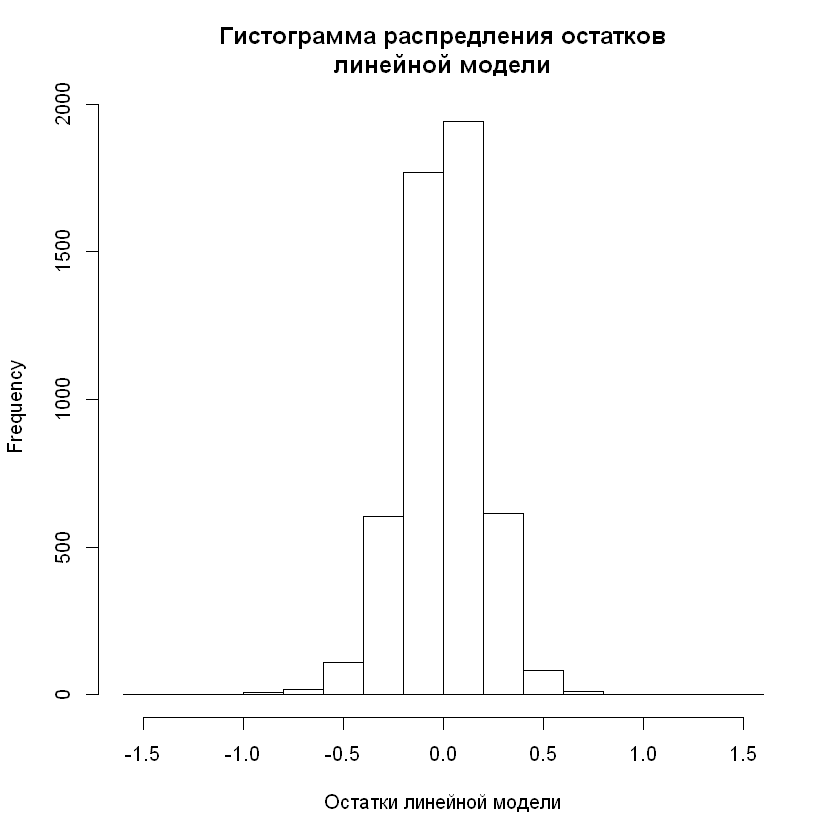

In [214]:
hist( lm_all_summary$residuals , main = 'Гистограмма распредления остатков\nлинейной модели', xlab = 'Остатки линейной модели')

График QQ-Plot для остатков

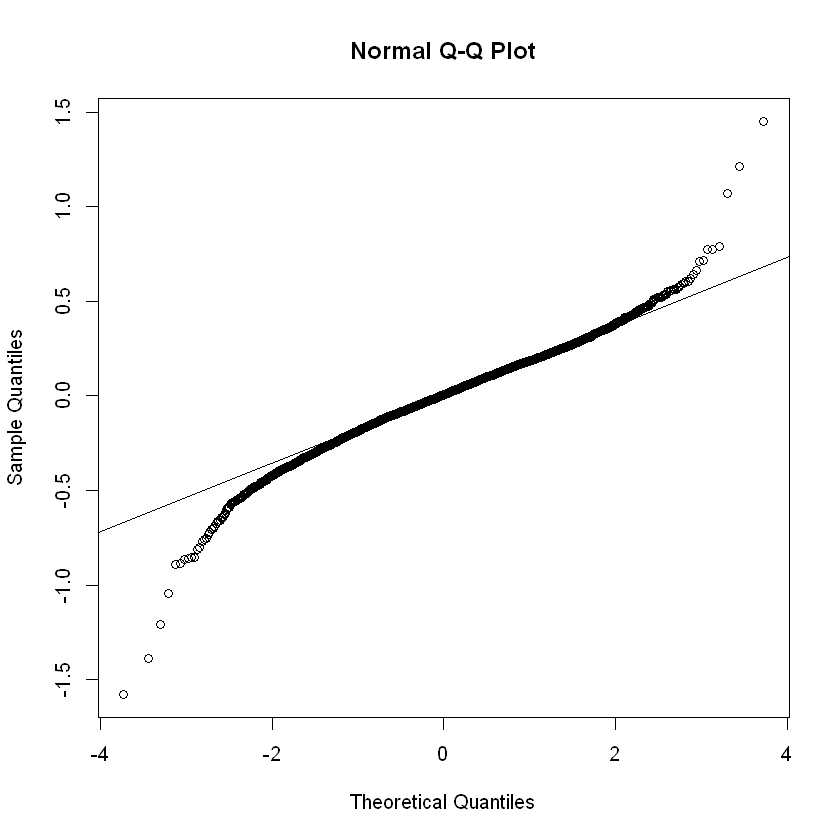

In [189]:
qqnorm( lm_all_summary$residuals )
qqline( lm_all_summary$residuals )

Проверка остатков на нормальность распределения тестом Колмогорова-Смирнова

In [190]:
ks.test(lm_all_summary$residuals, 'pnorm')

Warning message in ks.test(lm_all_summary$residuals, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  lm_all_summary$residuals
D = 0.33385, p-value < 2.2e-16
alternative hypothesis: two-sided


Тест Колмогорова-Смирнова показал, что остатки распределены ненормально

ВЫВОДЫ:

Линейная модель содержит следующие признаки, влияющие на логарифм цены:
* Категориальные
    - Mark
    - Location
    - Fuel_Type
    - Transmission
    - Owner_Type
    - SEATS
    - YEAR
    - Mil_sections
* Числовые 
    - Mileage * Engine * Power
    - Mileage * Engine * Power
    - Kilometers_Driven * Mileage*Power      
    - Kilometers_Driven * Engine * Power        
    - Mileage * Engine * Power 
    - Mileage * Power                        
    - Engine * Power  
    - Kilometers_Driven * Power
    - Engine                                  
    - Power
    - Kilometers_Driven
   
Из вышеприведенного следует, что на цену влияют числовые признаки и их взаимодействия. Поскольку зависимая переменная логарифмирована, то коэффициенты при числовых признаках показывают, на сколько процентов меняется цена при изменении признака на единицу.

Например, коэффициент при Power равен 0.0137. Тогда при изменении признака на единицу цена изменится на
$$(exp{(0.0137)}-1)\times100\% \approx 1.379\%$$. 

Данная модель объясняет 90% дисперсии в данных (Исправленный коэффициент равен 0.9).